In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetV2L, ResNet152V2
from tensorflow.keras.models import Model as model
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


In [2]:

def EfficientNet():
    Gibon = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    Gibon.trainable = True
    x = Gibon.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    return model(inputs=Gibon.input, outputs=x)

def ResNet():
    Gibon = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    Gibon.trainable = True
    x = Gibon.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    return model(inputs=Gibon.input, outputs=x)

def FinalModel():
    EF = EfficientNet()
    RN = ResNet()

    Hapchingu = Concatenate()([EF.output, RN.output])
    x = Dense(256, activation='relu')(Hapchingu)
    x = Dropout(0.3)(x)
    x = Dense(3, activation='softmax', dtype='float32')(x)

    Hapchingu1 = model(inputs=[EF.input, RN.input], outputs=x)
    return Hapchingu1

def Loading(train_dir, test_dir):
    train_data = image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset='training',
        seed=123,
        image_size=(224, 224),
        batch_size=8)

    val_data = image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset='validation',
        seed=123,
        image_size=(224, 224),
        batch_size=8)

    test_data = image_dataset_from_directory(
        test_dir,
        image_size=(224, 224),
        batch_size=8,
        shuffle=False)

    return train_data, val_data, test_data

def augment(image, label):
    image = tf.image.random_contrast(image, lower=0.9031330915128971, upper=1.0478198204494218)
    return image, label

def prepare_inputs(dataset):
    dataset = dataset.map(lambda x, y: ((x, x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def plot_history(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.show()


In [3]:
train_path = 'C:/Users/jhh33/Desktop/train'
test_path = 'C:/Users/jhh33/Desktop/test'
jujang_path = 'C:/Users/jhh33/Desktop/untitled6.keras'

random_seed = 0
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

train_ds, val_ds, test_ds = Loading(train_path, test_path)

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = prepare_inputs(train_ds)
val_ds = prepare_inputs(val_ds)
test_ds = prepare_inputs(test_ds)

Hapchingu1 = FinalModel()
Hapchingu1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3.125524609928448e-05), 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(jujang_path, save_best_only=True, save_weights_only=False)

history = Hapchingu1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[early_stopping, model_checkpoint]
)

test_loss, test_accuracy = Hapchingu1.evaluate(test_ds)
print("Test Accuracy:", test_accuracy)
print("Test Loss",test_loss)

Found 1950 files belonging to 3 classes.
Using 1560 files for training.
Found 1950 files belonging to 3 classes.
Using 390 files for validation.
Found 270 files belonging to 3 classes.
Epoch 1/3
195/195 [==============================] - 307s 970ms/step - loss: 0.5025 - accuracy: 0.8045 - val_loss: 0.1287 - val_accuracy: 0.9744
Epoch 2/3
195/195 [==============================] - 176s 904ms/step - loss: 0.0624 - accuracy: 0.9865 - val_loss: 0.0494 - val_accuracy: 0.9872
Epoch 3/3
34/34 [==============================] - 7s 189ms/step - loss: 0.0173 - accuracy: 1.0000
Test Accuracy: 1.0
Test Loss 0.017264600843191147


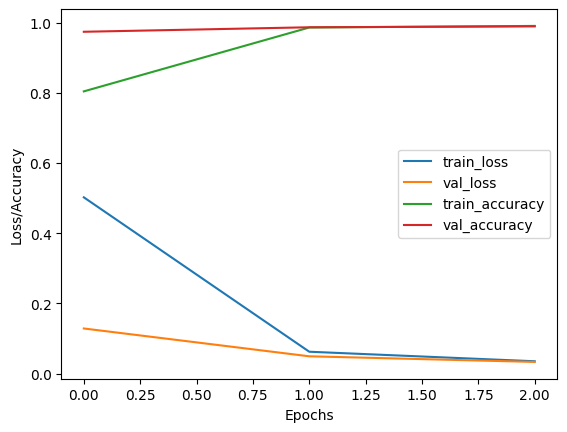

In [4]:
plot_history(history)